# 3.1 signac-flow minimal example

## About

This notebook contains a minimal example for running a signac-flow project from scratch.
The example demonstrates how to compare an ideal gas with a lennard jones fluid by calculating a p-V phase diagram.

## Author

Carl Simon Adorf

## Before you start

Make sure you installed signac and signac-flow, e.g., with:

```
conda install -c conda-forge  signac
conda install -c glotzer  signac-flow
```

In [1]:
import signac
import flow
import numpy as np


# Enter the signac project directory
project = signac.init_project('FlowTutorialProject', 'projects/tutorial-signac-flow')

We want to generate a pressure-volume (p-V) phase diagram for an ideal gas.

We define a function to calculate the result for a given state point:

In [2]:
def V_idg(N, p, kT):
    return N * kT / p

We want to use **signac** to manage our data, therefore we define an *operation* which has only the *signac job* as argument:

In [3]:
def compute_volume(job):
    job.document['V'] = V_idg(** job.statepoint())

For this demonstration we will specialize a `flow.FlowProject` to manage our simple *workflow*.

The workflow is controlled by two core functions: `label()` and `next_operation()`:
 - The `labels()` function allows us to *label* our jobs and get a good overview of the project *status*. This is especially important once the data space becomes larger and more complex and operations more expensive.
 - The `next_operation()` functions helps to automate the workflow by identifying the next required operation for each job.
 
 In this case there is only **one** operation:

In [6]:
class MyProject(flow.FlowProject):
    
    def labels(self, job):
        yield 'init'
        if 'V' in job.document:
            yield 'estimated'
    
    def next_operation(self, job):
        labels = set(self.labels(job))
        if 'V' not in job.document:
            return 'compute_volume'

We need to use the `get_project()` *class method* to get a project handle for this special project class.

In [7]:
project = MyProject.get_project(root='projects/tutorial-signac-flow')

Now it's time to actually generate some data! Let's initialize the data space!


In [8]:
for p in np.linspace(0.5, 5.0, 10):
    sp = dict(N=1728, kT=1.0, p=p)
    project.open_job(sp).init()

The `print_status()` function allows to get a quick overview of our project's *status*:

In [9]:
project.print_status(detailed=True, parameters=['p'])


Overview:

Total # of jobs: 10

label    ratio
-------  --------------------------------------------------
init     |████████████████████████████████████████| 100.00%

operation
-----------


Detailed View:

job_id                            operation      p  labels
--------------------------------  -----------  ---  --------
f3f3c351f81acd2140edd239b9183af4  [ ]          3.5  init
4b299db86ff480f92e520eac91112108  [ ]          1.5  init
26e2f19b5b211edb80ebe60a5a62bd75  [ ]          2    init
46859989efcfd89653fa65db2375884b  [ ]          3    init
6f9bc79d670e42d4a40041ce7be9cdaf  [ ]          5    init
b38e30524c2c36e3ebfe50481eb91992  [ ]          4    init
75c10d0fa7a4f4b4742ce5e9c119e8bd  [ ]          2.5  init
bb277ac022ce744d38f9e87c1fabe08c  [ ]          4.5  init
55d4d6ebbc04a1f8a259a2c5de197328  [ ]          1    init
a14ee3104f26974b22bb84f62500c84d  [ ]          0.5  init

[U]:unknown [R]:registered [Q]:queued [A]:active [I]:inactive [!]:requires_attention




The next cell will attempt to execute all operations by cycling through jobs and operations until no *next operations* are defined anymore.

We limit the max. number of cycles to prevent accidental infinite loops, the number of cycles is arbitrary.

In [10]:
for i in range(3):
    for job in project:
        for j in range(5):
            next_op = project.next_operation(job)
            if next_op is None:
                break
            print('execute', job, next_op)
            globals()[next_op](job)
            assert next_op != project.next_operation(job)
        else:
            raise RuntimeError("Reached max. # cycle limit!")

execute f3f3c351f81acd2140edd239b9183af4 compute_volume
execute 4b299db86ff480f92e520eac91112108 compute_volume
execute 26e2f19b5b211edb80ebe60a5a62bd75 compute_volume
execute 46859989efcfd89653fa65db2375884b compute_volume
execute 6f9bc79d670e42d4a40041ce7be9cdaf compute_volume
execute b38e30524c2c36e3ebfe50481eb91992 compute_volume
execute 75c10d0fa7a4f4b4742ce5e9c119e8bd compute_volume
execute bb277ac022ce744d38f9e87c1fabe08c compute_volume
execute 55d4d6ebbc04a1f8a259a2c5de197328 compute_volume
execute a14ee3104f26974b22bb84f62500c84d compute_volume


Let's double check the project status.

In [11]:
project.print_status()


Overview:

Total # of jobs: 10

label      ratio
---------  --------------------------------------------------
init       |████████████████████████████████████████| 100.00%
estimated  |████████████████████████████████████████| 100.00%

operation
-----------





After running all operations we can make a brief examination of the collected data.

In [12]:
for job in project:
    print(job.statepoint()['p'], job.document.get('V'))

3.5 493.7142857142857
1.5 1152.0
2.0 864.0
3.0 576.0
5.0 345.6
4.0 432.0
2.5 691.2
4.5 384.0
1.0 1728.0
0.5 3456.0


For a better presentation of the results we need to aggregate all results and sort them by pressure.

[3456.0, 1728.0, 1152.0, 864.0, 691.2, 576.0, 493.7142857142857, 432.0, 384.0, 345.6]


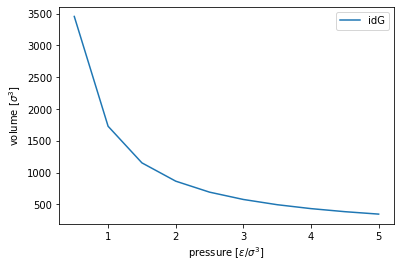

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

V = dict()

for job in project:
    V[job.statepoint()['p']] = job.document['V']
    
p = sorted(V.keys())
V = [V[p_] for p_ in p]
print(V)

plt.plot(p, V, label='idG')
plt.xlabel(r'pressure [$\epsilon / \sigma^3$]')
plt.ylabel(r'volume [$\sigma^3$]')
plt.legend()

As a a final step, we ca generate a index of our project data.
You can store this index in a variable or within a database, e.g., for search operations.

In [ ]:
for doc in project.index():
    print(doc)

Uncomment and execute the following line to remove all data and start over.

In [5]:
#% rm -r projects/tutorial-signac-flow/workspace